In [1]:
from bbq.utils import *
from bbq.polynomial import Polynomial, Monomial
from bbq.bbq_code import BivariateBicycle
from bbq.decoder import bp_osd, _permute_field
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import galois
from scipy.sparse import coo_matrix, hstack
import json
from datetime import datetime
from bbq.field import Field

## Final loop nonsense

In [6]:
P = np.array([[[0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.45 , 0.1  , 0.2  , 0.1  , 0.15 ],
        [0.21 , 0.37 , 0.19 , 0.17 , 0.06 ],
        [0.2  , 0.2  , 0.1  , 0.35 , 0.15 ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.185, 0.13 , 0.205, 0.285, 0.195],
        [0.365, 0.11 , 0.18 , 0.175, 0.17 ],
        [0.222, 0.312, 0.162, 0.167, 0.137],
        [0.215, 0.175, 0.16 , 0.295, 0.155]],

       [[0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.18 , 0.23 , 0.145, 0.3  , 0.145],
        [0.24 , 0.35 , 0.11 , 0.145, 0.155],
        [0.131, 0.271, 0.321, 0.156, 0.121],
        [0.295, 0.225, 0.13 , 0.16 , 0.19 ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.13 , 0.205, 0.285, 0.195, 0.185],
        [0.11 , 0.18 , 0.175, 0.17 , 0.365],
        [0.162, 0.312, 0.222, 0.137, 0.167],
        [0.295, 0.155, 0.215, 0.175, 0.16 ]]])
err_neighbourhood = {2: np.array([[0, 1],
       [1, 1],
       [2, 2],
       [3, 2]]), 3: np.array([[0, 1],
       [1, 1],
       [2, 2],
       [3, 3]]), 4: np.array([[0, 2],
       [1, 2],
       [2, 3],
       [3, 4]]), 1: np.array([[1, 1],
       [2, 1],
       [3, 2]])}
prior = np.array([[0.2, 0.3, 0.1, 0.25, 0.15],
                  [0.25, 0.2, 0.3, 0.15, 0.1],
                  [0.15, 0.25, 0.2, 0.3, 0.1],
                  [0.1, 0.15, 0.25, 0.2, 0.3],
                  [0.3, 0.1, 0.15, 0.25, 0.2]])

In [8]:
err_neighbourhood[2][:, 0]

array([0, 1, 2, 3])

In [191]:
ch_posteriors = np.zeros((5, 5))

for i, dets in err_neighbourhood.items():
    # TODO: Vectorize this:
    print(np.prod(P[dets[:, 0], i, :], axis=0))
    print(prior[i, :])
    print('--------------------')
    posterior = np.prod(P[dets[:, 0], i, :], axis=0) * prior[i, :]
    ch_posteriors[i, :] = posterior

[0.0043362  0.000693   0.000693   0.00043137 0.00144266]
[0.15 0.25 0.2  0.3  0.1 ]
--------------------
[0.00098937 0.00976068 0.00219344 0.00060675 0.0001661 ]
[0.1  0.15 0.25 0.2  0.3 ]
--------------------
[0.00374207 0.00122062 0.0004472  0.002891   0.0007068 ]
[0.3  0.1  0.15 0.25 0.2 ]
--------------------
[0.004329   0.0061295  0.00847162 0.0166725  0.00523087]
[0.25 0.2  0.3  0.15 0.1 ]
--------------------


In [208]:
ch_posteriors == posteriors

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [180]:
keys = list(err_neighbourhood.keys())

In [206]:
np.array([np.prod(P[err_neighbourhood[i][:, 0], i, :], axis=0) for i in keys]) * prior[keys, :]

array([[6.50430000e-04, 1.73250000e-04, 1.38600000e-04, 1.29412500e-04,
        1.44266250e-04],
       [9.89369640e-05, 1.46410243e-03, 5.48361090e-04, 1.21350216e-04,
        4.98304620e-05],
       [1.12262250e-03, 1.22062500e-04, 6.70800000e-05, 7.22750000e-04,
        1.41360000e-04],
       [1.08225000e-03, 1.22590000e-03, 2.54148750e-03, 2.50087500e-03,
        5.23087500e-04]])

In [207]:
posteriors = np.zeros((5, 5))
posteriors[keys, :] = np.array([np.prod(P[err_neighbourhood[i][:, 0], i, :], axis=0) for i in keys]) * prior[keys, :]

In [202]:
i=2
P[err_neighbourhood[i][:, 0], i, :]

array([[0.45 , 0.1  , 0.2  , 0.1  , 0.15 ],
       [0.365, 0.11 , 0.18 , 0.175, 0.17 ],
       [0.24 , 0.35 , 0.11 , 0.145, 0.155],
       [0.11 , 0.18 , 0.175, 0.17 , 0.365]])

In [198]:
np.prod(np.array([P[err_neighbourhood[i][:, 0], i, :] for i in keys]), axis=1)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [190]:
np.prod(np.array([P[dets[:, 0], i, :] for i in keys]), axis=1) * prior[keys, :]

array([[0.0014454 , 0.0017325 , 0.000693  , 0.00129412, 0.00096178],
       [0.00047113, 0.00395703, 0.00288611, 0.00071382, 0.00083051],
       [0.00561311, 0.00061031, 0.0006708 , 0.002065  , 0.0009424 ],
       [0.00108225, 0.0012259 , 0.00254149, 0.00250088, 0.00052309]])

In [183]:
posteriors = np.zeros((5, 5))
posteriors[keys, :] = np.prod(np.array([P[dets[:, 0], i, :] for i in keys]), axis=1) * prior[keys]

In [189]:
posteriors

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00108225, 0.0012259 , 0.00254149, 0.00250088, 0.00052309],
       [0.0014454 , 0.0017325 , 0.000693  , 0.00129412, 0.00096178],
       [0.00047113, 0.00395703, 0.00288611, 0.00071382, 0.00083051],
       [0.00561311, 0.00061031, 0.0006708 , 0.002065  , 0.0009424 ]])

In [137]:
posteriors

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.08225000e-03, 1.22590000e-03, 2.54148750e-03, 2.50087500e-03,
        5.23087500e-04],
       [6.50430000e-04, 1.73250000e-04, 1.38600000e-04, 1.29412500e-04,
        1.44266250e-04],
       [9.89369640e-05, 1.46410243e-03, 5.48361090e-04, 1.21350216e-04,
        4.98304620e-05],
       [1.12262250e-03, 1.22062500e-04, 6.70800000e-05, 7.22750000e-04,
        1.41360000e-04]])

In [ ]:
x = np.array([[[1, 2], 
              [2, 3]],
              [[3, 4], 
              [4, 5]]])
a = np.array([[0, 3],
              [1, 2]])

In [118]:
x[0]

array([[1, 2],
       [2, 3]])

In [121]:
np.prod(x, axis=1)

array([[ 2,  6],
       [12, 20]])

In [115]:
y = np.zeros((x.shape[1], x.shape[2]), dtype=int)

for i in range(x.shape[0]):
    z = np.prod(x[i], axis=0) * a[i, :]
    y[i] = z

In [116]:
y

array([[ 0, 18],
       [12, 40]])

In [126]:
xx = np.prod(x, axis=1)
xx

array([[ 2,  6],
       [12, 20]])

In [127]:
a

array([[0, 3],
       [1, 2]])

In [128]:
xx * a

array([[ 0, 18],
       [12, 40]])

In [125]:
np.einsum('ij, ik', xx, a)

array([[12, 30],
       [20, 58]])

## rfft nonsense

In [86]:
x = np.array([[0.1, 0.2, 0.5, 0.1, 0.1], [0.1, 0.2, 0.5, 0.1, 0.1], [0.3, 0.2, 0.1, 0.3, 0.1], [0.1, 0.2, 0.5, 0.1, 0.1]])

In [94]:
x = np.arange(100*500).reshape(100, 500)

In [50]:
x = [0.1, 0.2, 0.5, 0.1, 0.1]

In [95]:
t = datetime.now()
for i in range(10):
    _ = np.fft.fft(x, axis=1)
print(f"Time taken for FFT: {datetime.now() - t}")

Time taken for FFT: 0:00:00.008942


In [96]:
t = datetime.now()
for i in range(10):
    _ = np.fft.rfft(x)
print(f"Time taken for FFT: {datetime.now() - t}")

Time taken for FFT: 0:00:00.004680


In [85]:
np.fft.irfft(np.fft.rfft(x), len(np.fft.rfft(x)))

array([0.41961198, 0.68432424, 0.01864312, 0.87742067])

In [83]:
x = [0, 1, 0, 0, 0, 1, 0]

In [58]:
y

array([ 1.       +0.j        , -0.2927051-0.33021975j,
        0.0427051+0.32164408j])

In [64]:
y2 = [1.       +0.j        , -0.2927051-0.33021975j,
        0.0427051+0.32164408j, -0.2927051+0.33021975j, 0.0427051-0.32164408j]

In [65]:
np.fft.irfft(y2)

array([-0.00533814,  0.03925084,  0.28477174,  0.20007288,  0.28736696,
        0.03925084, -0.04544801,  0.20007288])

## Benchmarking

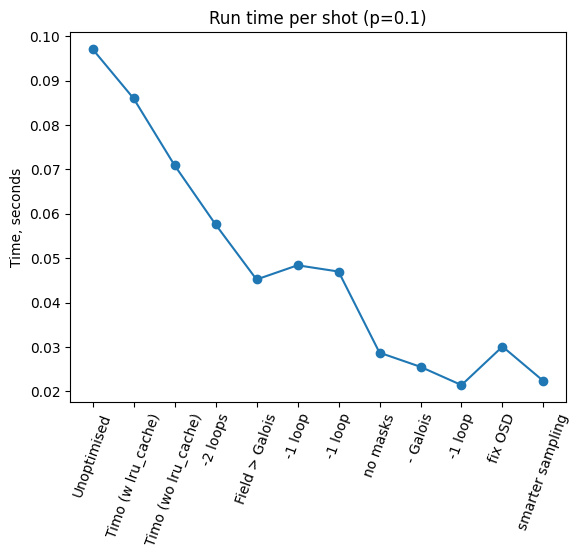

In [327]:
time = [0.097124, 0.086013, 0.070947, 0.057622, 0.045219, 0.048417, 0.047008, 0.028732, 0.025541, 0.021428, 0.030110, 0.022331]

plt.plot(time, marker='o')
plt.title('Run time per shot (p=0.1)')
# plt.xlabel('Optimising steps...')
plt.ylabel('Time, seconds')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Unoptimised', 'Timo (w lru_cache)', 'Timo (wo lru_cache)', '-2 loops', 'Field > Galois', '-1 loop', '-1 loop', 'no masks', '- Galois', '-1 loop', 'fix OSD', 'smarter sampling'])
plt.xticks(rotation=70);

## Utils

In [3]:
def rref_with_pivots(A, v, x = None):
    """
    Perform Gaussian elimination to find the reduced row echelon form (RREF).
    Also identifies the pivot columns.
    Also reduces a vector to keep a linear system invariant.
    
    Parameters
    ----------
    A : Galois field array
        Galois field matrix to row reduce
        
    Returns
    -------
    A_rref : Galois field array
        Row-reduced form of A
    pivots : list
        Indices of pivot columns
    """
    # Get a copy to avoid modifying the original
    A_rref = A.copy()
    v_rref = v.copy()
    m, n = A_rref.shape
    assert v.shape == (m,)
    # assert (A_rref @ x == v_rref).all()
    
    # Track the pivot positions
    pivot_cols = []
    pivot_rows = []
    
    # Iterate through columns
    for c in range(n):
        # Find pivot in column c
        for r in range(m):
            if A_rref[r, c] != 0 and r not in pivot_rows:
                break
        else:
            continue

        # Record this column as a pivot column
        pivot_cols.append(c)
        pivot_rows.append(r)
        
        # Scale the pivot row to make the pivot element 1
        pivot = A_rref[r, c]
        A_rref[r] = A_rref[r] / pivot
        v_rref[r] = v_rref[r] / pivot
        
        # Eliminate other elements in the pivot column
        for i in range(m):
            if i != r and A_rref[i, c] != 0:
                v_rref[i] = v_rref[i] - A_rref[i,c] * v_rref[r]
                A_rref[i] = A_rref[i] - A_rref[i, c] * A_rref[r]
        
        # If we've exhausted all rows, we're done
        if len(pivot_rows) == m:
            break
    
    # if len(pivot_rows) < A.shape[0]:
    #     print("Matrix is not full rank.")

    return A_rref[sorted(pivot_rows)], v_rref[sorted(pivot_rows)], pivot_cols

In [4]:
def dijkstra_osd_decode(self, syndrome_history, prior, h_eff, debug = False):
    """Decode the syndrome using D+OSD.
    
    Parameters
    ----------
    syndrome_history : nd.array
        The syndrome of the error.
    prior : nd.array
        The probability of each error mechanism.
    h_eff : nd.array
        The effective parity check matrix, where columns = error mechanism and rows = syndrome (flagged stabilisers).

    Returns
    -------
    error : nd.array
        The estimated error.
    """
    if not isinstance(syndrome_history, np.ndarray):
        raise TypeError('syndrome must be a numpy array')
    if not isinstance(prior, np.ndarray):
        raise TypeError('prior must be a np.ndarray')

    field = self.field
    qubits_dict = self.qubits_dict
    data_qubits, x_checks, z_checks = self.data_qubits, self.x_checks, self.z_checks

    m, n = h_eff.shape

    # Mini-Dijkstra
    check_distances = np.ones(m) * n
    error_distances = np.ones(n) * n

    # Set the distance each detector is from an error
    for c in syndrome_history.nonzero()[0]:
        check_distances[c] = 0

    update_made = True
    while update_made:
        update_made = False
        for c in range(m):
            current_distance = check_distances[c]
            for e in np.nonzero(h_eff[c])[0]:
                if current_distance + 1 < error_distances[e]:
                    error_distances[e] = current_distance + 1
                    update_made = True

        for e in range(n):
            current_distance = error_distances[e]
            for c in np.nonzero(h_eff[:,e])[0]:
                if current_distance + 1 < check_distances[c]:
                    check_distances[c] = current_distance + 1
                    update_made = True

    certainties = error_distances

    # Sort errors by how certain we are of their values (most to least)
    col_rank_perm = np.argsort(certainties)
    col_rank_inv_perm = np.empty_like(col_rank_perm)
    col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))

    # Create Galois field elements
    GF = galois.GF(field)
    
    # Convert H and syndrome to Galois field arrays
    H_gf = GF(h_eff.copy())
    syndrome_gf = GF(syndrome_history.copy())
    
    # Order the columns of h_gf and prior according to the ranking
    H_ordered_gf = H_gf[:, col_rank_perm]
    priors_perm = prior[col_rank_perm]

    # Find the reduced row echelon form (RREF) and identify pivot columns
    H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
    m_ind = H_rref_gf.shape[0]
    non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

    # Select the first rank(h_gf) linearly independent columns as basis set in P, others in B
    P = H_rref_gf[:, pivot_cols]
    assert P.shape == (m_ind, m_ind)
    B = H_rref_gf[:, non_pivot_cols]

    def sln_from(g):
        assert g.shape == (n - m_ind,)
        remainder =  syndrome_rref_gf - B @ g
        fix = np.linalg.solve(P, remainder)
        assert (P @ fix + B @ g == syndrome_rref_gf).all()

        score = 0
        sln = GF.Zeros(n)
        # Find prob of basis set
        for i in range(m_ind):
            p = priors_perm[pivot_cols[i], fix[i]]
            sln[pivot_cols[i]] = fix[i]
            if p > 0:
                score += np.log(p)
            else:
                p -= 1000
        
        for i in range(n - m_ind):
            p = priors_perm[non_pivot_cols[i], g[i]]
            sln[non_pivot_cols[i]] = g[i]
            if p > 0:
                score += np.log(p)
            else:
                p -= 1000

        # Check sln makes correct syndrome
        assert (H_rref_gf @ sln == syndrome_rref_gf).all()
        assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()
    
        return np.array(sln[col_rank_inv_perm]), score

    # OSD_0 solution
    best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
    pivot_col_labels = {col_rank_perm[c]: int(error_distances[col_rank_perm[c]]) for c in pivot_cols}
    
    # print(f'for debugging: {best_solution}, {True}, {[col_rank_perm[i] for i in pivot_cols]}, {pivot_col_labels}')
    
    return best_solution

## Experiment 1: Qudit Toric Code under Code Capacity (varying distance)

In [231]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 10
# results_cap_qubit = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = results_cap_qubit[d]
    for ind, p in enumerate(np.logspace(-3, -1, 20)[4:6]):
        failures = 0
        num_trials = 0
        if d == 5:
            if p < 0.002:
                res.append(np.inf)
                continue
        if d == 7:
            if p < 0.003:
                res.append(np.inf)
                continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lz) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        res[ind+4] = num_trials
        print(f'Finished p={p} for d={d}')
    print(f'Completed d={d}')
    results_cap_qubit[d] = res

Found 1 / 10, with num_trials : 674
Found 2 / 10, with num_trials : 1394
Found 3 / 10, with num_trials : 3932
Found 4 / 10, with num_trials : 4024
Found 5 / 10, with num_trials : 4964
Found 6 / 10, with num_trials : 5180
Found 7 / 10, with num_trials : 5646
Found 8 / 10, with num_trials : 7249
Found 9 / 10, with num_trials : 7925
Found 10 / 10, with num_trials : 8358
Finished p=0.0026366508987303583 for d=9
Found 1 / 10, with num_trials : 772
Found 2 / 10, with num_trials : 1009
Found 3 / 10, with num_trials : 1288
Found 4 / 10, with num_trials : 1454
Found 5 / 10, with num_trials : 1647
Found 6 / 10, with num_trials : 1677
Found 7 / 10, with num_trials : 1690
Found 8 / 10, with num_trials : 1830
Found 9 / 10, with num_trials : 2361
Found 10 / 10, with num_trials : 2595
Finished p=0.003359818286283781 for d=9
Completed d=9


In [232]:
results_cap_qubit

{3: [56086,
  33751,
  31160,
  26242,
  16380,
  14568,
  10186,
  9096,
  6300,
  5155,
  3740,
  3090,
  2451,
  1694,
  1218,
  910,
  656,
  536,
  394,
  308],
 5: [58090,
  27627,
  27949,
  135376,
  102331,
  63479,
  40411,
  29084,
  16645,
  8727,
  6208,
  3383,
  2380,
  1438,
  911,
  757,
  483,
  345,
  236,
  191],
 7: [inf,
  inf,
  13472,
  10380,
  5719,
  50926,
  20708,
  14464,
  11397,
  6149,
  3730,
  2651,
  1604,
  1063,
  699,
  521,
  355,
  254,
  187,
  167],
 9: [inf,
  inf,
  inf,
  inf,
  8359,
  2596,
  9818,
  6785,
  3069,
  2274,
  1267,
  1102,
  644,
  393,
  256,
  179,
  110,
  103,
  93,
  70]}

In [268]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

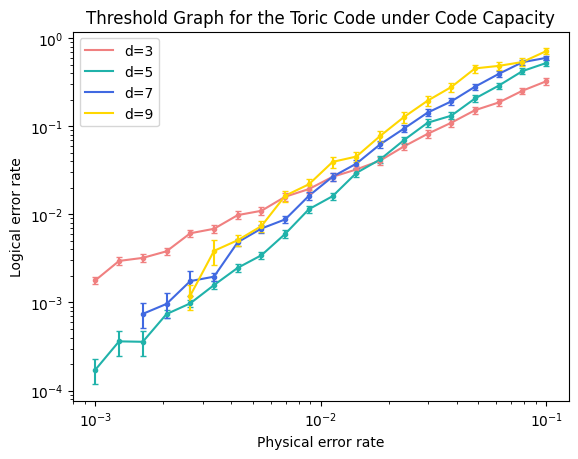

In [239]:
# Plotting

x = np.logspace(-3, -1, 20)
num_failures = {3 : 100, 5 : np.array(3*[10] + 17*[100]), 7 : np.array(5*[10] + 15*[100]), 9 : np.array(6*[10] + 14*[50])}
plot_results, plot_error_bars = process_results(results_cap_qubit, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x[:], plot_results[5][:], color='lightseagreen')
plt.loglog(x[2:], plot_results[7][2:], color='royalblue')
plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x[:], plot_results[5][:], yerr=plot_error_bars[5][:], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x[2:], plot_results[7][2:], yerr=plot_error_bars[7][2:], fmt='.', capsize=2.5, color='royalblue')
plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

In [87]:
results_cap_qubit

{3: [0.001,
  0.003,
  0.005,
  0.003,
  0.007,
  0.007,
  0.009,
  0.01,
  0.012,
  0.024,
  0.028,
  0.03,
  0.047,
  0.07,
  0.074,
  0.106,
  0.157,
  0.195,
  0.26,
  0.32],
 5: [0.0,
  0.0,
  0.0,
  0.003,
  0.004,
  0.0,
  0.004,
  0.003,
  0.003,
  0.014,
  0.021,
  0.027,
  0.047,
  0.061,
  0.105,
  0.15,
  0.217,
  0.313,
  0.443,
  0.524],
 7: [0.0,
  0.002,
  0.0,
  0.002,
  0.002,
  0.001,
  0.002,
  0.006,
  0.009,
  0.015,
  0.032,
  0.035,
  0.079,
  0.089,
  0.135,
  0.206,
  0.289,
  0.403,
  0.541,
  0.615],
 9: [0.0,
  0.0,
  0.0,
  0.001,
  0.004,
  0.006,
  0.001,
  0.005,
  0.01,
  0.028,
  0.035,
  0.05,
  0.077,
  0.131,
  0.175,
  0.249,
  0.353,
  0.471,
  0.593,
  0.666]}

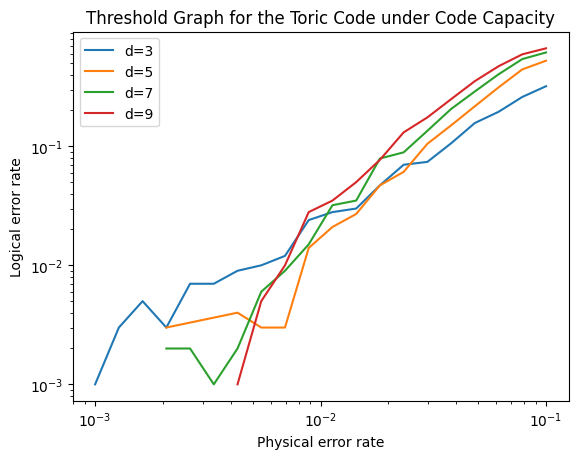

In [104]:
# Plotting

x = np.logspace(-3, -1, 20)

plt.loglog(x, results_cap_qubit[3])
plt.loglog(np.append(x[3:4], x[6:]), np.append(results_cap_qubit[5][3:4], results_cap_qubit[5][6:]))
plt.loglog(x[3:], results_cap_qubit[7][3:])
plt.loglog(x[6:], results_cap_qubit[9][6:])

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

In [247]:
# Code capacity model for qudit (field=3) Toric code with varying distance

field = 3

a = Polynomial(field, np.array([[1, 0], [field-1, 0]]))
b = Polynomial(field, np.array([[1, field-1], [0, 0]]))

num_failures = 10
# results_cap_qudit_3 = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = results_cap_qudit_3[d]
    for ind, p in enumerate(np.logspace(-3, -1, 20)[4:6]):
        failures = 0
        num_trials = 0
        if d == 5:
            if p < 0.002:
                res.append(np.inf)
                continue
        if d == 7:
            if p < 0.003:
                res.append(np.inf)
                continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            
            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
            num_trials += 1
        res[ind+4] = num_trials
        print(f'Finished p={p} for d={d}, with num_trials : {num_trials}')
    print(f'Completed d={d}')
    results_cap_qudit_3[d] = res

Found 1 / 10, with num_trials : 372
Found 2 / 10, with num_trials : 1090
Found 3 / 10, with num_trials : 1398
Found 4 / 10, with num_trials : 1884
Found 5 / 10, with num_trials : 2403
Found 6 / 10, with num_trials : 3289
Found 7 / 10, with num_trials : 4625
Found 8 / 10, with num_trials : 5595
Found 9 / 10, with num_trials : 5994
Found 10 / 10, with num_trials : 6221
Finished p=0.0026366508987303583 for d=9, with num_trials : 6222
Found 1 / 10, with num_trials : 495
Found 2 / 10, with num_trials : 784
Found 3 / 10, with num_trials : 837
Found 4 / 10, with num_trials : 925
Found 5 / 10, with num_trials : 999
Found 6 / 10, with num_trials : 1719
Found 7 / 10, with num_trials : 2236
Found 8 / 10, with num_trials : 2714
Found 9 / 10, with num_trials : 3306
Found 10 / 10, with num_trials : 3643
Finished p=0.003359818286283781 for d=9, with num_trials : 3644
Completed d=9


In [248]:
results_cap_qudit_3

{3: [24454,
  21314,
  19118,
  11947,
  9042,
  6364,
  5893,
  4035,
  3631,
  3018,
  2364,
  1653,
  1309,
  821,
  858,
  560,
  514,
  420,
  268,
  241],
 5: [67635,
  54654,
  21265,
  139463,
  83938,
  52569,
  32302,
  18185,
  11752,
  8206,
  5676,
  3206,
  2373,
  1205,
  719,
  665,
  411,
  223,
  187,
  167],
 7: [inf,
  inf,
  15679,
  13033,
  8038,
  38208,
  28893,
  15452,
  10498,
  6214,
  3347,
  2433,
  1426,
  1018,
  586,
  440,
  304,
  216,
  171,
  132],
 9: [inf,
  inf,
  inf,
  inf,
  6222,
  3644,
  15543,
  12210,
  7176,
  4694,
  3055,
  1829,
  1157,
  676,
  496,
  345,
  253,
  168,
  144,
  119]}

In [ ]:
# long one...
results_cap_qudit_3

{3: [24454,
  21314,
  19118,
  11947,
  9042,
  6364,
  5893,
  4035,
  3631,
  3018,
  2364,
  1653,
  1309,
  821,
  858,
  560,
  514,
  420,
  268,
  241],
 5: [inf,
  inf,
  inf,
  139463,
  83938,
  52569,
  32302,
  18185,
  11752,
  8206,
  5676,
  3206,
  2373,
  1205,
  719,
  665,
  411,
  223,
  187,
  167],
 7: [inf,
  inf,
  inf,
  inf,
  inf,
  38208,
  28893,
  15452,
  10498,
  6214,
  3347,
  2433,
  1426,
  1018,
  586,
  440,
  304,
  216,
  171,
  132],
 9: [inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  15543,
  12210,
  7176,
  4694,
  3055,
  1829,
  1157,
  676,
  496,
  345,
  253,
  168,
  144,
  119]}

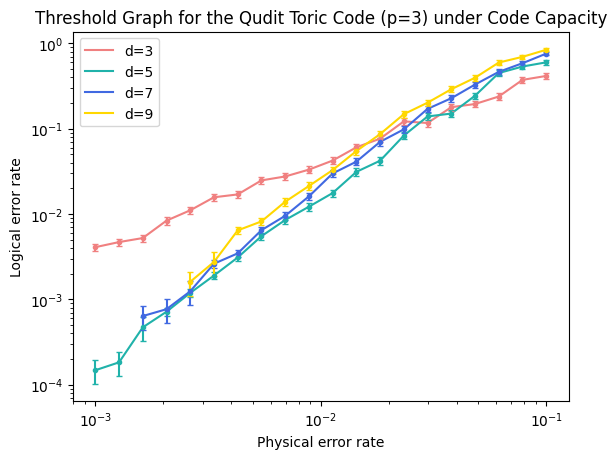

In [249]:
# Plotting

x = np.logspace(-3, -1, 20)
num_failures = {3 : 100, 5 : np.array(3*[10] + 17*[100]), 7 : np.array(5*[10] + 15*[100]), 9 : np.array(6*[10] + 14*[100])}
plot_results, plot_error_bars = process_results(results_cap_qudit_3, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x[:], plot_results[5][:], color='lightseagreen')
plt.loglog(x[2:], plot_results[7][2:], color='royalblue')
plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x[:], plot_results[5][:], yerr=plot_error_bars[5][:], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x[2:], plot_results[7][2:], yerr=plot_error_bars[7][2:], fmt='.', capsize=2.5, color='royalblue')
plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Qudit Toric Code (p=3) under Code Capacity');

In [63]:
results_cap_qudit_3

{3: [0.007,
  0.006,
  0.011,
  0.011,
  0.019,
  0.013,
  0.01,
  0.023,
  0.024,
  0.033,
  0.04,
  0.055,
  0.064,
  0.098,
  0.118,
  0.175,
  0.231,
  0.288,
  0.344,
  0.448],
 5: [0.0,
  0.0,
  0.001,
  0.0,
  0.001,
  0.002,
  0.003,
  0.001,
  0.011,
  0.015,
  0.016,
  0.03,
  0.052,
  0.075,
  0.133,
  0.162,
  0.274,
  0.363,
  0.484,
  0.621],
 7: [0.0,
  0.0,
  0.001,
  0.0,
  0.002,
  0.002,
  0.004,
  0.005,
  0.01,
  0.022,
  0.029,
  0.038,
  0.068,
  0.105,
  0.158,
  0.236,
  0.314,
  0.464,
  0.617,
  0.716],
 9: [0.0,
  0.002,
  0.001,
  0.001,
  0.0,
  0.0,
  0.003,
  0.007,
  0.014,
  0.022,
  0.038,
  0.055,
  0.061,
  0.146,
  0.214,
  0.302,
  0.426,
  0.502,
  0.689,
  0.773]}

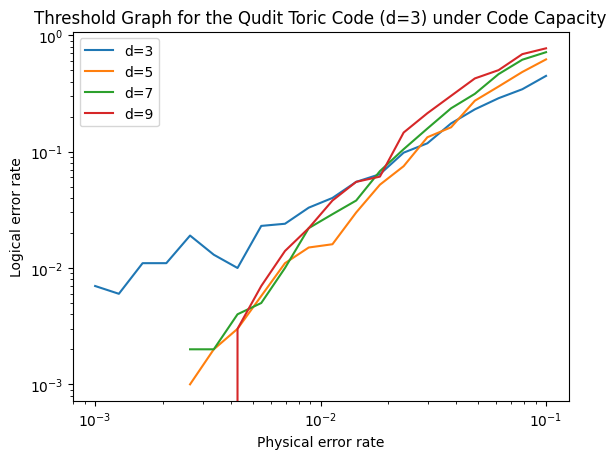

In [54]:
# Plotting

x = np.logspace(-3, -1, 20)

plt.loglog(x, results_cap_qudit_3[3])
plt.loglog(np.append(x[4:7], x[8:]), np.append(results_cap_qudit_3[5][4:7], results_cap_qudit_3[5][8:]))
plt.loglog(x[4:], results_cap_qudit_3[7][4:])
plt.loglog(x[5:], results_cap_qudit_3[9][5:])

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Qudit Toric Code (d=3) under Code Capacity');

In [250]:
# Code capacity model for qudit (field=5) Toric code with varying distance

field = 5

a = Polynomial(field, np.array([[1, 0], [field-1, 0]]))
b = Polynomial(field, np.array([[1, field-1], [0, 0]]))

num_failures = 100
results_cap_qudit_5 = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [3, 5, 7, 9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = []
    for p in np.logspace(-3, -1, 20):
        failures = 0
        num_trials = 0
        if d == 5:
            if p < 0.002:
                res.append(np.inf)
                continue
        if d == 7:
            if p < 0.003:
                res.append(np.inf)
                continue
        if d == 9:
            if p < 0.004:
                res.append(np.inf)
                continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                # print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            
            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
            num_trials += 1
        res.append(num_trials)
        print(f'Finished p={p} for d={d}, with num_trials : {num_trials}')
    print(f'Completed d={d}')
    results_cap_qudit_5[d] = res

Finished p=0.001 for d=3, with num_trials : 26248
Finished p=0.0012742749857031334 for d=3, with num_trials : 19024
Finished p=0.001623776739188721 for d=3, with num_trials : 16425
Finished p=0.00206913808111479 for d=3, with num_trials : 10911
Finished p=0.0026366508987303583 for d=3, with num_trials : 8206
Finished p=0.003359818286283781 for d=3, with num_trials : 7684
Finished p=0.004281332398719396 for d=3, with num_trials : 5262
Finished p=0.00545559478116852 for d=3, with num_trials : 4726
Finished p=0.0069519279617756054 for d=3, with num_trials : 4004
Finished p=0.008858667904100823 for d=3, with num_trials : 2910
Finished p=0.011288378916846888 for d=3, with num_trials : 2238
Finished p=0.01438449888287663 for d=3, with num_trials : 1654
Finished p=0.018329807108324356 for d=3, with num_trials : 1335
Finished p=0.023357214690901212 for d=3, with num_trials : 820
Finished p=0.029763514416313176 for d=3, with num_trials : 802
Finished p=0.0379269019073225 for d=3, with num_trial

In [251]:
results_cap_qudit_5

{3: [26248,
  19024,
  16425,
  10911,
  8206,
  7684,
  5262,
  4726,
  4004,
  2910,
  2238,
  1654,
  1335,
  820,
  802,
  584,
  422,
  372,
  251,
  194],
 5: [inf,
  inf,
  inf,
  147302,
  83714,
  56467,
  31239,
  20903,
  11857,
  9332,
  4968,
  3532,
  1543,
  1415,
  944,
  517,
  366,
  258,
  210,
  169],
 7: [inf,
  inf,
  inf,
  inf,
  inf,
  35461,
  21608,
  16373,
  9312,
  6637,
  3728,
  2531,
  1465,
  915,
  618,
  436,
  271,
  195,
  178,
  136],
 9: [inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  15917,
  13246,
  6723,
  4896,
  2816,
  2072,
  1218,
  806,
  518,
  363,
  221,
  180,
  141,
  118]}

In [265]:
# Code capacity model for qudit (field=5) Toric code with varying distance

field = 5

a = Polynomial(field, np.array([[1, 0], [field-1, 0]]))
b = Polynomial(field, np.array([[1, field-1], [0, 0]]))

num_failures = 10
# results_cap_qudit_5 = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [9]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    res = results_cap_qudit_5[d]
    for ind, p in enumerate(np.logspace(-3, -1, 20)[4:6]):
        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            
            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
            num_trials += 1
        res[ind+4] = num_trials
        print(f'Finished p={p} for d={d}, with num_trials : {num_trials}')
    print(f'Completed d={d}')
    results_cap_qudit_5[d] = res

Found 1 / 10, with num_trials : 732
Found 2 / 10, with num_trials : 865
Found 3 / 10, with num_trials : 1099
Found 4 / 10, with num_trials : 2068
Found 5 / 10, with num_trials : 2096
Found 6 / 10, with num_trials : 2264
Found 7 / 10, with num_trials : 3084
Found 8 / 10, with num_trials : 3455
Found 9 / 10, with num_trials : 3546
Found 10 / 10, with num_trials : 3595
Finished p=0.0026366508987303583 for d=9, with num_trials : 3596
Found 1 / 10, with num_trials : 1388
Found 2 / 10, with num_trials : 1651
Found 3 / 10, with num_trials : 1688
Found 4 / 10, with num_trials : 2318
Found 5 / 10, with num_trials : 2480
Found 6 / 10, with num_trials : 2668
Found 7 / 10, with num_trials : 2704
Found 8 / 10, with num_trials : 3110
Found 9 / 10, with num_trials : 3258
Found 10 / 10, with num_trials : 3680
Finished p=0.003359818286283781 for d=9, with num_trials : 3681
Completed d=9


In [266]:
results_cap_qudit_5

{3: [26248,
  19024,
  16425,
  10911,
  8206,
  7684,
  5262,
  4726,
  4004,
  2910,
  2238,
  1654,
  1335,
  820,
  802,
  584,
  422,
  372,
  251,
  194],
 5: [81441,
  26161,
  26474,
  147302,
  83714,
  56467,
  31239,
  20903,
  11857,
  9332,
  4968,
  3532,
  1543,
  1415,
  944,
  517,
  366,
  258,
  210,
  169],
 7: [inf,
  inf,
  25412,
  10716,
  8348,
  35461,
  21608,
  16373,
  9312,
  6637,
  3728,
  2531,
  1465,
  915,
  618,
  436,
  271,
  195,
  178,
  136],
 9: [inf,
  inf,
  inf,
  inf,
  3596,
  3681,
  15917,
  13246,
  6723,
  4896,
  2816,
  2072,
  1218,
  806,
  518,
  363,
  221,
  180,
  141,
  118]}

In [ ]:
# long one...

results_cap_qudit_5

{3: [26248,
  19024,
  16425,
  10911,
  8206,
  7684,
  5262,
  4726,
  4004,
  2910,
  2238,
  1654,
  1335,
  820,
  802,
  584,
  422,
  372,
  251,
  194],
 5: [inf,
  inf,
  inf,
  147302,
  83714,
  56467,
  31239,
  20903,
  11857,
  9332,
  4968,
  3532,
  1543,
  1415,
  944,
  517,
  366,
  258,
  210,
  169],
 7: [inf,
  inf,
  inf,
  inf,
  inf,
  35461,
  21608,
  16373,
  9312,
  6637,
  3728,
  2531,
  1465,
  915,
  618,
  436,
  271,
  195,
  178,
  136],
 9: [inf,
  inf,
  inf,
  inf,
  inf,
  inf,
  15917,
  13246,
  6723,
  4896,
  2816,
  2072,
  1218,
  806,
  518,
  363,
  221,
  180,
  141,
  118]}

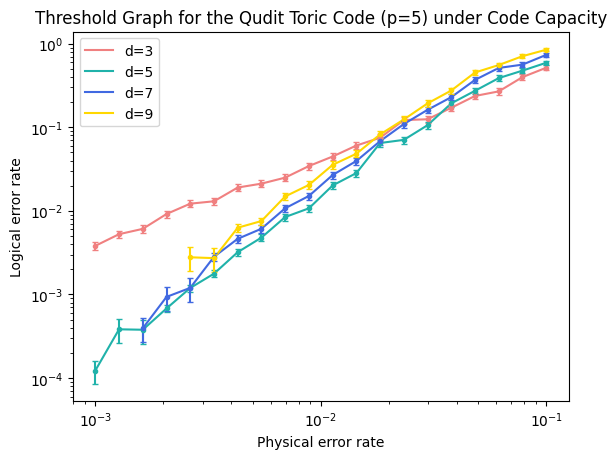

In [267]:
# Plotting

x = np.logspace(-3, -1, 20)
num_failures = {3 : 100, 5 : np.array(3*[10] + 17*[100]), 7 : np.array(5*[10] + 15*[100]), 9 : np.array(6*[10] + 14*[100])}
plot_results, plot_error_bars = process_results(results_cap_qudit_5, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x[:], plot_results[5][:], color='lightseagreen')
plt.loglog(x[2:], plot_results[7][2:], color='royalblue')
plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x[:], plot_results[5][:], yerr=plot_error_bars[5][:], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x[2:], plot_results[7][2:], yerr=plot_error_bars[7][2:], fmt='.', capsize=2.5, color='royalblue')
plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Qudit Toric Code (p=5) under Code Capacity');

In [64]:
results_cap_qudit_5

{3: [0.005,
  0.006,
  0.007,
  0.006,
  0.005,
  0.012,
  0.012,
  0.022,
  0.027,
  0.041,
  0.054,
  0.068,
  0.076,
  0.092,
  0.133,
  0.184,
  0.222,
  0.292,
  0.349,
  0.459],
 5: [0.0,
  0.0,
  0.0,
  0.001,
  0.0,
  0.001,
  0.003,
  0.005,
  0.009,
  0.023,
  0.022,
  0.036,
  0.044,
  0.071,
  0.111,
  0.175,
  0.249,
  0.381,
  0.506,
  0.661],
 7: [0.0,
  0.0,
  0.0,
  0.001,
  0.002,
  0.001,
  0.006,
  0.012,
  0.008,
  0.015,
  0.019,
  0.045,
  0.07,
  0.118,
  0.165,
  0.256,
  0.341,
  0.492,
  0.638,
  0.785],
 9: [0.002,
  0.001,
  0.001,
  0.0,
  0.003,
  0.005,
  0.007,
  0.007,
  0.019,
  0.024,
  0.037,
  0.059,
  0.083,
  0.136,
  0.197,
  0.299,
  0.399,
  0.594,
  0.733,
  0.845]}

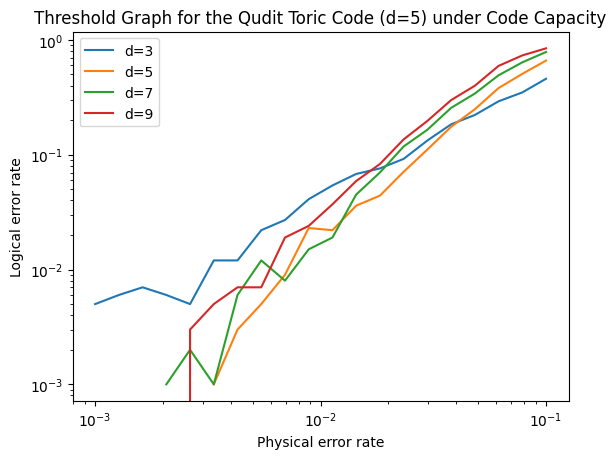

In [62]:
# Plotting

x = np.logspace(-3, -1, 20)

plt.loglog(x, results_cap_qudit_5[3])
plt.loglog(x[5:], results_cap_qudit_5[5][5:])
plt.loglog(x[3:], results_cap_qudit_5[7][3:])
plt.loglog(x[3:], results_cap_qudit_5[9][3:])

plt.legend(['d=3', 'd=5', 'd=7', 'd=9'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Qudit Toric Code (d=5) under Code Capacity');

## Experiment 2: Qudit Toric Code under Code Capacity (varying field)

In [105]:
# Compare dimensions

results_cap_all_qudits = {}
results_cap_all_qudits[2] = results_cap_qubit[7]
results_cap_all_qudits[3] = results_cap_qudit_3[7]
results_cap_all_qudits[5] = results_cap_qudit_5[7]

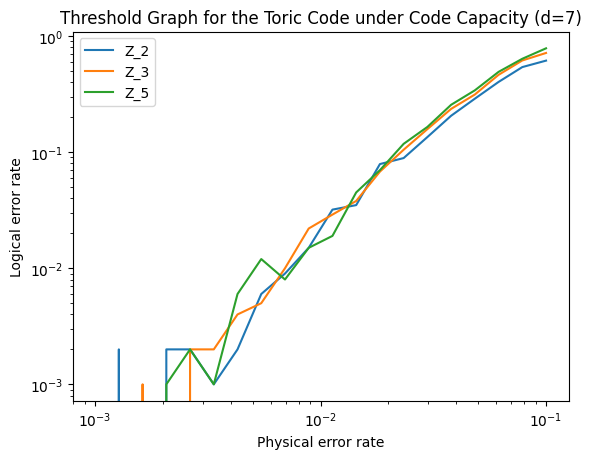

In [108]:
# Plotting

x = np.logspace(-3, -1, 20)
for field in [2, 3, 5]:
    plt.loglog(x, results_cap_all_qudits[field])
plt.legend(['Z_2', 'Z_3', 'Z_5'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity (d=7)');

## Experiment 3: Qudit BB under Code Capacity

In [269]:
# [[72, 12, 6]]

a = Polynomial(2, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bb0 = BivariateBicycle(a, b, 6, 6, 1)

In [270]:
# [[90, 8, 10]]

a = Polynomial(2, np.array([[1], [0], [1], [0], [0], [0], [0], [1]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bb1 = BivariateBicycle(a, b, 3, 15, 1)

In [271]:
# [[144, 12, 12]] Gross Code

a = Polynomial(2, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bb2 = BivariateBicycle(a, b, 6, 12, 1)

In [283]:
# [[288, 12, 18]]

# a = x^3+y^2+y^7, b = y^3 + x^2 + x
a = Polynomial(2, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(2, np.array([[0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0]]))
bb3 = BivariateBicycle(a, b, 12, 12, 1)

In [340]:
num_failures = 5
# results_cap_qudit_ibm = []

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for ind, bb in enumerate([bb2, bb3]):
    lz = bb.z_logicals
    res = results_cap_qudit_ibm[ind+1]
    for p in np.logspace(-3, -1, 10):
        failures = 0
        num_trials = 0
        if ind == 0 and p == 0.001:
            continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lz) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 10 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
            num_trials += 1
        res.append(num_trials)
        print(f'Finished p={p} for d={d}, with num_trials : {num_trials}')
    print(f'Completed bb{ind}')
    results_cap_qudit_ibm[ind+1] = res

Found 1 / 5, with num_trials : 1914
Found 2 / 5, with num_trials : 4210
Found 3 / 5, with num_trials : 5438
Found 4 / 5, with num_trials : 6371
Found 5 / 5, with num_trials : 7333
Finished p=0.0016681005372000592 for d=9, with num_trials : 7334
Found 1 / 5, with num_trials : 79
Found 2 / 5, with num_trials : 414
Found 3 / 5, with num_trials : 1129
Found 4 / 5, with num_trials : 1499
Found 5 / 5, with num_trials : 1598
Finished p=0.0027825594022071257 for d=9, with num_trials : 1599
Found 1 / 5, with num_trials : 1
Found 2 / 5, with num_trials : 115
Found 3 / 5, with num_trials : 159
Found 4 / 5, with num_trials : 298
Found 5 / 5, with num_trials : 966
Finished p=0.004641588833612777 for d=9, with num_trials : 967
Found 1 / 5, with num_trials : 34
Found 2 / 5, with num_trials : 142
Found 3 / 5, with num_trials : 148
Found 4 / 5, with num_trials : 183
Found 5 / 5, with num_trials : 234
Finished p=0.007742636826811269 for d=9, with num_trials : 235
Found 1 / 5, with num_trials : 30
Found 

In [341]:
results_cap_qudit_ibm

[[12882, 4580, 1600, 483, 209, 107, 50, 16, 11, 11],
 [8592, 7334, 1599, 967, 235, 103, 19, 12, 9, 5],
 [10102, 3095, 1418, 352, 140, 72, 27, 6, 5, 5]]

In [339]:
results_cap_qudit_ibm

[[12882, 4580, 1600, 483, 209, 107, 50, 16, 11, 11], [8592], []]

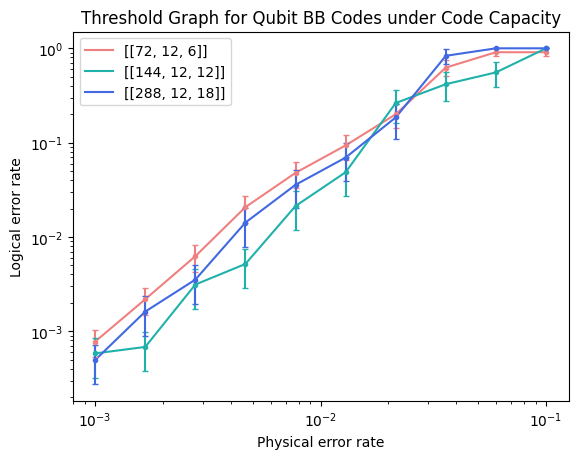

In [345]:
# Plotting

results = {}
results[3] = results_cap_qudit_ibm[0]
results[5] = results_cap_qudit_ibm[1]
results[7] = results_cap_qudit_ibm[2]

x = np.logspace(-3, -1, 10)
num_failures = {3 : 10*[10], 5 : np.array(10*[5]), 7 : np.array(10*[5])}
plot_results, plot_error_bars = process_results(results, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x[:], plot_results[5][:], color='lightseagreen')
plt.loglog(x[:], plot_results[7][:], color='royalblue')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x[:], plot_results[5][:], yerr=plot_error_bars[5][:], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x[:], plot_results[7][:], yerr=plot_error_bars[7][:], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['[[72, 12, 6]]', '[[144, 12, 12]]', '[[288, 12, 18]]'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for Qubit BB Codes under Code Capacity');

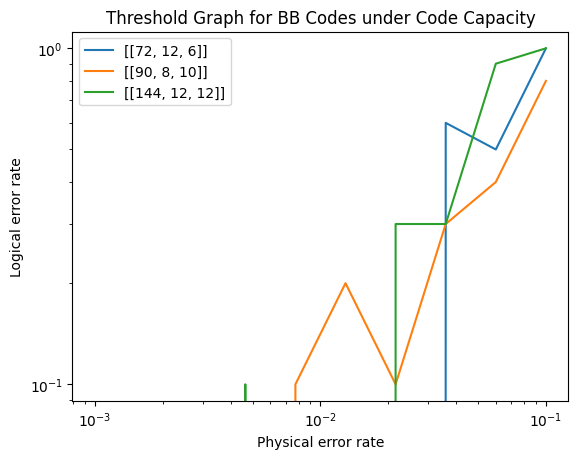

In [ ]:
# Plotting

x = np.logspace(-3, -1, 20)
for d in range(3):
    plt.loglog(x, results_cap_qudit_ibm[d])
plt.legend(['[[72, 12, 6]]', '[[90, 8, 10]]', '[[144, 12, 12]]'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for BB Codes under Code Capacity');

## Experiment 4: Qudit Gross Code esque under Code Capacity (varying field)

In [ ]:
# [[72, 12, 6]]

a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg0 = BivariateBicycle(a, b, 6, 6, 1)

In [ ]:
# [[90, 8, 10]]

a = Polynomial(2, np.array([[1], [0], [1], [0], [0], [0], [0], [1]]))
b = Polynomial(2, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg1 = BivariateBicycle(a, b, 3, 15, 1)

In [ ]:
# [[144, 12, 12]] Gross Code

a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg2 = BivariateBicycle(a, b, 6, 12, 1)

In [ ]:
# [[288, 12, 18]]

# a = x^3+y^2+y^7, b = y^3 + x^2 + x
a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0]]))
bbg3 = BivariateBicycle(a, b, 12, 12, 1)

In [ ]:
# Code capacity model for qudit Gross code with varying field

failures = 0
num_trials = 5
results_cap_qudit_gross2 = []

for bb in [bbg1, bbg2]:
    lz = bb.z_logicals
    res = []
    field = bb.field
    for p in np.logspace(-3, -1, 20):
        failures = 0
        for _ in range(num_trials):
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
        res.append(failures/num_trials)
    print(f'Completed bb={bb}')
    results_cap_qudit_gross2.append(res)

Completed bb=Bivariate Bicycle code for
a(x, y) = 0x^0y^0 + 0x^0y^1 + 0x^0y^2 + 1x^0y^3 + 1x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^1y^3 + 1x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^2y^3
b(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 1x^3y^0 + 0x^3y^1 + 0x^3y^2
Completed bb=Bivariate Bicycle code for
a(x, y) = 0x^0y^0 + 0x^0y^1 + 0x^0y^2 + 1x^0y^3 + 1x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^1y^3 + 1x^2y^0 + 0x^2y^1 + 0x^2y^2 + 0x^2y^3
b(x, y) = 0x^0y^0 + 1x^0y^1 + 1x^0y^2 + 0x^1y^0 + 0x^1y^1 + 0x^1y^2 + 0x^2y^0 + 0x^2y^1 + 0x^2y^2 + 1x^3y^0 + 0x^3y^1 + 0x^3y^2


In [81]:
results_cap_qudit_gross

[[0.001,
  0.003,
  0.001,
  0.003,
  0.004,
  0.009,
  0.013,
  0.035,
  0.024,
  0.047,
  0.083,
  0.123,
  0.151,
  0.259,
  0.371,
  0.491,
  0.616,
  0.778,
  0.896,
  0.956],
 [0.002,
  0.0,
  0.0,
  0.005,
  0.006,
  0.004,
  0.004,
  0.007,
  0.025,
  0.029,
  0.045,
  0.088,
  0.132,
  0.198,
  0.316,
  0.426,
  0.584,
  0.733,
  0.845,
  0.928],
 [0.0,
  0.001,
  0.002,
  0.001,
  0.002,
  0.007,
  0.008,
  0.011,
  0.028,
  0.031,
  0.073,
  0.09,
  0.137,
  0.19,
  0.299,
  0.443,
  0.562,
  0.716,
  0.85,
  0.935]]

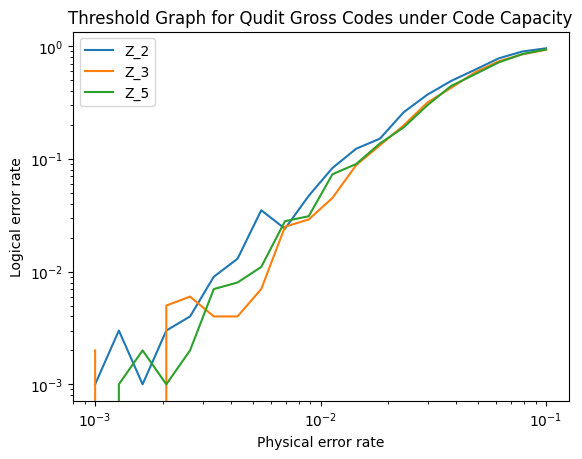

In [85]:
# Plotting

x = np.logspace(-3, -1, 20)
for d in range(3):
    plt.loglog(x, results_cap_qudit_gross[d])
plt.legend(['Z_2', 'Z_3', 'Z_5'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for Qudit Gross Codes under Code Capacity');

In [346]:
# [[72, 12, 6]]

a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg0 = BivariateBicycle(a, b, 6, 6, 1)

In [347]:
# [[144, 12, 12]] Gross Code

a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0], [1, 0, 0]]))
bbg2 = BivariateBicycle(a, b, 6, 12, 1)

In [348]:
# [[288, 12, 18]]

# a = x^3+y^2+y^7, b = y^3 + x^2 + x
a = Polynomial(3, np.array([[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0]]))
b = Polynomial(3, np.array([[0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0]]))
bbg3 = BivariateBicycle(a, b, 12, 12, 1)

In [368]:
grr = list(np.logspace(-3, -1, 10))
grr.reverse()
grr = np.array(grr)

In [369]:
grr

array([0.1       , 0.05994843, 0.03593814, 0.02154435, 0.0129155 ,
       0.00774264, 0.00464159, 0.00278256, 0.0016681 , 0.001     ])

In [370]:
# Code capacity model for qudit Gross code with varying field

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

num_failures = 5
results_cap_qudit_gross22 = []

for bb in [bbg3]:
    lz = bb.z_logicals
    res = []
    field = bb.field
    for p in grr:
        failures = 0
        num_trials = 0
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (bb.hx @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=int)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            guessed_error = dijkstra_osd_decode(bb, syndrome, x_prior, bb.hx)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(lz) @ error_difference) % field

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 10 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
            num_trials += 1
        res.append(num_trials)
        print(f'Finished p={p} for d={d}, with num_trials : {num_trials}')
    print(f'Completed bb{ind}')
    results_cap_qudit_gross22.append(res)

Found 1 / 5, with num_trials : 0
Found 2 / 5, with num_trials : 1
Found 3 / 5, with num_trials : 2
Found 4 / 5, with num_trials : 3
Found 5 / 5, with num_trials : 4
Finished p=0.1 for d=9, with num_trials : 5
Found 1 / 5, with num_trials : 0
Found 2 / 5, with num_trials : 2
Found 3 / 5, with num_trials : 3
Found 4 / 5, with num_trials : 4
Found 5 / 5, with num_trials : 5
Finished p=0.05994842503189409 for d=9, with num_trials : 6
Found 1 / 5, with num_trials : 3
Found 2 / 5, with num_trials : 6
Found 3 / 5, with num_trials : 7
Found 4 / 5, with num_trials : 8
Found 5 / 5, with num_trials : 11
Finished p=0.03593813663804626 for d=9, with num_trials : 12
Found 1 / 5, with num_trials : 1
Found 2 / 5, with num_trials : 3
Found 3 / 5, with num_trials : 7
Found 4 / 5, with num_trials : 15
Found 5 / 5, with num_trials : 18
Finished p=0.021544346900318832 for d=9, with num_trials : 19
Found 1 / 5, with num_trials : 2
Found 2 / 5, with num_trials : 5
Found 3 / 5, with num_trials : 10
Found 4 / 

KeyboardInterrupt: 

## Experiment 5: Circuit Level

In [112]:
results_circ_3 = np.array([0.1 , 0.08, 0.07, 0.09, 0.24, 0.25, 0.36, 0.42, 0.5 , 0.5 ])
results_circ_5 = np.array([0.12, 0.15, 0.37, 0.38, 0.33, 0.52, 0.56, 0.63, 0.69, 0.72])
results_circ_7 = np.array([0.28, 0.29, 0.4 , 0.39, 0.57, 0.61, 0.67, 0.72, 0.77, 0.74])

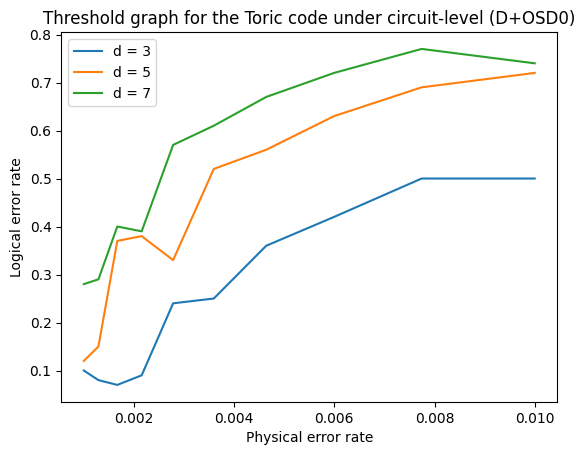

In [114]:
# BIG threshold graph

x = np.logspace(-3, -2, 10)

plt.plot(x, results_circ_3)
plt.plot(x, results_circ_5)
plt.plot(x, results_circ_7)

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend(['d = 3', 'd = 5', 'd = 7'])
plt.title('Threshold graph for the Toric code under circuit-level (D+OSD0)');